<a href="https://colab.research.google.com/github/multimediary/portfolio-data-science/blob/main/fraud-modeling-CDR-DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. IMPORT LIBRARY**

In [1]:
# For ignore warning
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Library For code execution time
!pip install ipython-autotime
%load_ext autotime

# Library For Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import homogeneity_score, silhouette_score

# Library For Clustering
from sklearn.cluster import DBSCAN
from sklearn import metrics

# Library For Visualization
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Library For Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

time: 683 ms (started: 2021-04-11 05:04:21 +00:00)


**2. DATA GATHERING**

In [2]:
# Read Dataset with Pandas from Git
df = pd.read_csv("https://raw.githubusercontent.com/multimediary/dataset/master/cdrwithfraude.csv")
df.head()

,starttime,stoptime,anumber,bnumber,duration,fee,destination,type,label
0,2018-05-02 09:13:24,2018-05-02 09:20:38,778692960,1500200,434,6000,callcenter,Injapati,0
1,2018-05-18 16:49:19,2018-05-18 16:52:11,778692960,1500200,172,2250,callcenter,Injapati,0
2,2018-05-18 18:15:17,2018-05-18 18:18:20,778692960,1500200,183,3000,callcenter,Injapati,0
3,2018-05-31 08:52:46,2018-05-31 08:53:03,778692253,1500788,17,750,callcenter,Injapati,0
4,2018-05-31 08:53:10,2018-05-31 08:53:24,778692253,1500788,14,750,callcenter,Injapati,0


time: 293 ms (started: 2021-04-11 05:04:22 +00:00)


In [3]:
# Show Dataset Description (Focus at Dtype)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   starttime    11418 non-null  object
 1   stoptime     11418 non-null  object
 2   anumber      11418 non-null  int64 
 3   bnumber      11418 non-null  object
 4   duration     11418 non-null  int64 
 5   fee          11418 non-null  int64 
 6   destination  11418 non-null  object
 7   type         11418 non-null  object
 8   label        11418 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 803.0+ KB
time: 14 ms (started: 2021-04-11 05:04:22 +00:00)


In [4]:
# Displays Dataframe Statistics (Focus at std)
df.describe()

,anumber,duration,fee,label
count,1.141800e+04,11418.000000,1.141800e+04,11418.000000
mean,7.786475e+08,154.111841,1.215145e+04,0.034770
std,3.985148e+04,410.204092,4.131463e+04,0.183204
min,7.786101e+08,0.000000,4.300000e+01,0.000000
25%,7.786133e+08,24.000000,6.340000e+02,0.000000
50%,7.786134e+08,57.000000,2.614000e+03,0.000000
75%,7.786930e+08,143.000000,1.045400e+04,0.000000
max,7.786978e+08,17735.000000,1.567841e+06,1.000000


time: 26.1 ms (started: 2021-04-11 05:04:22 +00:00)


In [5]:
# Show dataset shape
df.shape

(11418, 9)

time: 3.51 ms (started: 2021-04-11 05:04:22 +00:00)


In [6]:
# Show the dataset labeled fraud (1) and non fraud (0)
df['label'].value_counts()

0    11021
1      397
Name: label, dtype: int64

time: 6.63 ms (started: 2021-04-11 05:04:22 +00:00)


In [7]:
# Show a comparison between the dataset labeled fraud and non-fraud
print(df['label'].value_counts() / df['label'].shape[0])

0    0.96523
1    0.03477
Name: label, dtype: float64
time: 11.1 ms (started: 2021-04-11 05:04:22 +00:00)


In [8]:
# Check what types of calls are there
df['type'].value_counts()

SLJJ          7093
SLI 001       4035
Lokal          153
SLI 007        102
VoIP 01017      21
Injapati        14
Name: type, dtype: int64

time: 7.68 ms (started: 2021-04-11 05:04:22 +00:00)


In [9]:
# Find null in the dataset
df.isnull().sum().max()

0

time: 13.9 ms (started: 2021-04-11 05:04:22 +00:00)


**3. DATA PREPARATION**

In [10]:
# Drop unneeded attributes, namely startime and stoptime, destination and label
dataset = df.drop(['starttime','stoptime','destination','label'], axis = 1)
label = df.label

time: 5.11 ms (started: 2021-04-11 05:04:22 +00:00)


In [11]:
# Encoding Dataset Function
enc = LabelEncoder()
def transforming(input, j):
    input.iloc[:,j] = enc.fit_transform(input.iloc[:,j])

# Change data in the form of objects / strings into numbers
for i in range(0,5):
    if(i!=2 or i!=3):
        transforming(dataset, i)

time: 21.9 ms (started: 2021-04-11 05:04:22 +00:00)


In [12]:
# Show Dataset 
dataset.head()

,anumber,bnumber,duration,fee,type
0,265,3236,431,447,0
1,265,3236,172,238,0
2,265,3236,183,294,0
3,225,3237,17,96,0
4,225,3237,14,96,0


time: 13.7 ms (started: 2021-04-11 05:04:22 +00:00)


In [13]:
# Transform data with Scaler to perform data normalization so that the data used does not have large deviations.
features = ['anumber', 'bnumber', 'duration', 'fee', 'type']
Final_Dataset = dataset.loc[:, features].values
Final_Dataset = StandardScaler().fit_transform(Final_Dataset)
Final_Dataset = pd.DataFrame(data = Final_Dataset, columns = features)

time: 8.6 ms (started: 2021-04-11 05:04:22 +00:00)


In [25]:
# Show the Final Dataset 
Final_Dataset.head()

,anumber,bnumber,duration,fee,type
0,1.097724,1.802827,1.697394,0.358047,-3.259819
1,1.097724,1.802827,0.250598,-0.376284,-3.259819
2,1.097724,1.802827,0.312045,-0.179525,-3.259819
3,0.540323,1.803923,-0.615244,-0.875207,-3.259819
4,0.540323,1.803923,-0.632003,-0.875207,-3.259819


time: 20.5 ms (started: 2021-04-11 05:05:34 +00:00)


In [15]:
# Show Final Dataset Description (Focus at Dtype)
Final_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11418 entries, 0 to 11417
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anumber   11418 non-null  float64
 1   bnumber   11418 non-null  float64
 2   duration  11418 non-null  float64
 3   fee       11418 non-null  float64
 4   type      11418 non-null  float64
dtypes: float64(5)
memory usage: 446.1 KB
time: 9.99 ms (started: 2021-04-11 05:04:22 +00:00)


In [16]:
# Displays Final_Dataset Statistics (Focus at std)
Final_Dataset.describe()

,anumber,bnumber,duration,fee,type
count,1.141800e+04,1.141800e+04,1.141800e+04,1.141800e+04,1.141800e+04
mean,-2.250511e-15,1.878959e-15,-6.163206e-16,-7.016049e-15,3.629611e-14
std,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00,1.000044e+00
min,-2.595056e+00,-1.743395e+00,-7.102079e-01,-1.212507e+00,-3.259819e+00
25%,-5.048034e-01,-8.346482e-01,-5.761419e-01,-9.314236e-01,-1.248220e+00
50%,-2.121680e-01,-5.083002e-02,-3.918012e-01,-2.849318e-01,7.633788e-01
75%,1.055919e+00,8.822999e-01,8.860188e-02,7.831852e-01,7.633788e-01
max,1.515775e+00,1.806115e+00,4.814428e+00,2.736715e+00,1.769178e+00


time: 32.8 ms (started: 2021-04-11 05:04:22 +00:00)


In [17]:
# Persiapan Dataset
X = Final_Dataset.to_numpy()
y = df.iloc[:, 8] # Label Fraud
y = np.array(y).astype(np.float)

time: 2.6 ms (started: 2021-04-11 05:04:22 +00:00)


In [18]:
X

array([[ 1.09772399,  1.80282727,  1.6973936 ,  0.35804655, -3.25981941],
       [ 1.09772399,  1.80282727,  0.25059827, -0.37628386, -3.25981941],
       [ 1.09772399,  1.80282727,  0.31204517, -0.17952547, -3.25981941],
       ...,
       [ 1.09772399,  1.78967688,  0.64162403,  1.18372906,  1.76917832],
       [ 1.09772399,  1.79077274, -0.69344965, -0.05303794,  1.76917832],
       [ 1.09772399,  1.79077274, -0.67110532, -0.05303794,  1.76917832]])

time: 5.09 ms (started: 2021-04-11 05:04:22 +00:00)


In [19]:
y

array([0., 0., 0., ..., 0., 0., 0.])

time: 3.62 ms (started: 2021-04-11 05:04:22 +00:00)


**4. DATA MODELING WITH DBSCAN**


Density-based spatial clustering of applications with noise (DBSCAN) is a well-known data clustering algorithm that is commonly used in data mining and machine learning. Based on a set of points (let’s think in a bidimensional space as exemplified in the figure), DBSCAN groups together points that are close to each other based on a distance measurement (usually Euclidean distance) and a minimum number of points. It also marks as outliers the points that are in low-density regions. (Towards Data Science, 2017)

In [20]:
# DBSCAN Parameters
dbscan  = DBSCAN(eps=1.67, min_samples=4, n_jobs=-1).fit(X)
# Obtain the predicted labels and calculate number of clusters
pred_labels = dbscan.labels_

time: 1.48 s (started: 2021-04-11 05:04:22 +00:00)


In [21]:
# Result of labeling by DBSCAN
print(set(pred_labels))

{0, 1, 2, 3}
time: 4.71 ms (started: 2021-04-11 05:04:24 +00:00)


In [22]:
# Number of Clusters
n_clusters = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Silhouette Coefficient: {silhouette_score(X, pred_labels):0.3f}')

Estimated number of clusters: 4
Silhouette Coefficient: 0.170
time: 2.81 s (started: 2021-04-11 05:04:24 +00:00)


In [36]:
# Duplicate Final Dataset and Add Column Labels DBSCAN
Final_Dataset_copy = Final_Dataset.copy()
Final_Dataset_copy['labels_dbscan'] = pred_labels

time: 3.13 ms (started: 2021-04-11 05:11:45 +00:00)


In [39]:
# Show Final Dataset Copy plus Labels DBSCAN 
Final_Dataset_copy.head()

,anumber,bnumber,duration,fee,type,labels_dbscan
0,1.097724,1.802827,1.697394,0.358047,-3.259819,0
1,1.097724,1.802827,0.250598,-0.376284,-3.259819,0
2,1.097724,1.802827,0.312045,-0.179525,-3.259819,0
3,0.540323,1.803923,-0.615244,-0.875207,-3.259819,0
4,0.540323,1.803923,-0.632003,-0.875207,-3.259819,0


time: 19.7 ms (started: 2021-04-11 05:13:49 +00:00)


In [44]:
# Count Labels
Final_Dataset_copy['labels_dbscan'].value_counts().sort_index()

0       11
1      156
2    11230
3       21
Name: labels_dbscan, dtype: int64

time: 10.4 ms (started: 2021-04-11 05:36:36 +00:00)


In [47]:
# Sort the number of cluster samples and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [0 3 1]
time: 8.27 ms (started: 2021-04-11 05:37:20 +00:00)


In [48]:
# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [ 11  21 156]
time: 1.69 ms (started: 2021-04-11 05:37:40 +00:00)


In [49]:
# Create a condition flagging fraud for the smallest clusters 
# When label 0, 3, or 1 then change into 1 (Fraud), else change into 0 (Non Fraud)
Final_Dataset_copy['labels_dbscan'] = np.where((Final_Dataset_copy['labels_dbscan'].isin([0, 3, 1])), 1 , 0)

time: 3.75 ms (started: 2021-04-11 05:43:14 +00:00)


In [51]:
#Show Final_Dataset_copy with Final labels_dbscan 
Final_Dataset_copy

,anumber,bnumber,duration,fee,type,labels_dbscan
0,1.097724,1.802827,1.697394,0.358047,-3.259819,1
1,1.097724,1.802827,0.250598,-0.376284,-3.259819,1
2,1.097724,1.802827,0.312045,-0.179525,-3.259819,1
3,0.540323,1.803923,-0.615244,-0.875207,-3.259819,1
4,0.540323,1.803923,-0.632003,-0.875207,-3.259819,1
...,...,...,...,...,...,...
11413,1.097724,1.789677,0.742174,1.183729,1.769178,1
11414,1.097724,1.789677,1.971112,1.601841,1.769178,1
11415,1.097724,1.789677,0.641624,1.183729,1.769178,1
11416,1.097724,1.790773,-0.693450,-0.053038,1.769178,1


time: 21.2 ms (started: 2021-04-11 05:46:26 +00:00)


In [53]:
# Count Fraud and Non Fraud from Final Dataset Copy
Final_Dataset_copy['labels_dbscan'].value_counts()

0    11230
1      188
Name: labels_dbscan, dtype: int64

time: 7.97 ms (started: 2021-04-11 05:46:41 +00:00)


**5. DATA VISUALIZATION WITH PCA**

In [55]:
plotX = Final_Dataset_copy

time: 1.22 ms (started: 2021-04-11 05:50:43 +00:00)


In [56]:
pca_2d = PCA(n_components=2)

time: 1.24 ms (started: 2021-04-11 05:50:46 +00:00)


In [57]:
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["labels_dbscan"], axis=1)))

time: 32.1 ms (started: 2021-04-11 05:50:49 +00:00)


In [58]:
PCs_2d.columns = ["PC1_2d", "PC2_2d"]

time: 1.11 ms (started: 2021-04-11 05:50:52 +00:00)


In [59]:
plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')

time: 2.89 ms (started: 2021-04-11 05:50:54 +00:00)


In [60]:
cluster0 = plotX[plotX["labels_dbscan"] == 0]
cluster1 = plotX[plotX["labels_dbscan"] == 1]

time: 11.2 ms (started: 2021-04-11 05:50:58 +00:00)


In [61]:
init_notebook_mode(connected=True)

time: 3.53 ms (started: 2021-04-11 05:51:00 +00:00)


In [63]:
#trace1 is for 'Cluster 0'
trace1 = go.Scatter(
                    x = cluster0["PC1_2d"],
                    y = cluster0["PC2_2d"],
                    mode = "markers",
                    name = "Non Fraud",
                    marker = dict(color = 'rgba(0, 0, 0, 0.8)'),
                    text = None)

#trace2 is for 'Cluster 1'
trace2 = go.Scatter(
                    x = cluster1["PC1_2d"],
                    y = cluster1["PC2_2d"],
                    mode = "markers",
                    name = "Fraud",
                    marker = dict(color = 'rgba(240, 52, 52, 0.8)'),
                    text = None)

data = [trace1, trace2]

title = "DBSCAN - PCA"

layout = dict(title = title,
              xaxis= dict(title= 'PC1',ticklen= 5,zeroline= False),
              yaxis= dict(title= 'PC2',ticklen= 5,zeroline= False)
             )

#Plot and save html
plotly.offline.plot({"data": data,
                     "layout": layout},
                     auto_open=True)

'temp-plot.html'

time: 474 ms (started: 2021-04-11 05:51:14 +00:00)


Download and Open File temp-plot.html to see the Graph, please screenshoot and Place in here.

![](https://raw.githubusercontent.com/multimediary/portfolio-data-science/main/screenshots/fraud-modeling-CDR-DBSCAN.jpg)    

**6. DATA EVALUATION WITH CONFUSION MATRIX**

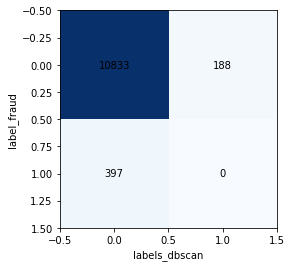

time: 189 ms (started: 2021-04-11 06:00:54 +00:00)


In [64]:
C = confusion_matrix(df["label"],plotX["labels_dbscan"])

# Plot confusion matrix
plt.imshow(C,interpolation='none',cmap='Blues')
for (i, j), z in np.ndenumerate(C):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("labels_dbscan")
plt.ylabel("label_fraud")
plt.show()

In [65]:
print(C)

[[10833   188]
 [  397     0]]
time: 1.47 ms (started: 2021-04-11 06:01:03 +00:00)


In [66]:
# Nilai Accuracy, Precision, Recall, and F1 Score
print("Accuracy Score of DBSCAN", accuracy_score(df["label"], plotX["labels_dbscan"]))
print("Recall of DBSCAN", recall_score(df["label"], plotX["labels_dbscan"],average=None, zero_division=1))
print("Precision Score of DBSCAN", precision_score(df["label"], plotX["labels_dbscan"],average=None, zero_division=1))
print("F1 Score of DBSCAN", f1_score(df["label"], plotX["labels_dbscan"],average=None, zero_division=1))

Accuracy Score of DBSCAN 0.9487651077246453
Recall of DBSCAN [0.98294166 0.        ]
Precision Score of DBSCAN [0.96464826 0.        ]
F1 Score of DBSCAN [0.97370905 0.        ]
time: 26.1 ms (started: 2021-04-11 06:01:06 +00:00)
